In [1]:
import numpy as np
import os 

import matplotlib
from matplotlib        import pyplot as plt
from matplotlib        import cm
from matplotlib.ticker import LinearLocator

WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from scipy.integrate import ode

In [2]:
#DIFFUSION-REACTION OF MULTIPLE SCALARS

ns = 50    # number of scalars
nx = 300   # number of collocation points
Lx = 1.0   # domain size 

dx = Lx/nx           # grid spacing
X  = np.zeros((ns,nx))
x  = np.zeros(nx*ns) 
for iS in range(0,ns):
    x[0+iS*nx:nx+iS*nx] = np.linspace(0., Lx-dx, nx)
    X[iS,:]             = np.linspace(0., Lx-dx, nx)
xx = x[0:nx]

#initial profile
sig = 0.05       
y0  = 1.0/(sig*np.sqrt(2.*np.pi)) * np.exp( -0.5*( (x-0.5 )/sig )**2.  )
#y0  = np.piecewise(x, [np.abs(x-0.5) < 0.05, np.abs(x-0.5) >= 0.05], [10, 0])


Y0 = np.zeros((ns,nx))
for iS in range(ns):
    Y0[iS,:] = 1.0 / ( sig*np.sqrt(2.*np.pi)) * np.exp( -0.5*( (X[iS,:]-0.5 )/sig )**2. )
    #Y0[iS,:] = np.piecewise(X[iS,:], [np.abs(X[iS,:]-0.5) < 0.05, np.abs(X[iS,:]-0.5) >= 0.05], [10, 0])

In [3]:
#RHS function
def ReacDiffAdvRHS_x(x, y, dx, xx, ns, DiffFun, AdvecFun, ReacFun, KInelT, KDiss, KRec):
    nx   = int(len(y)/ns)
    dydt = np.zeros(y.shape[0])
    
    Y = np.zeros((ns, nx))
    for iS in range(ns):
        Y[iS,:] = y[0+iS*nx:nx+iS*nx]
        
#     dYdt  = np.zeros((ns,nx))
#     dYdxx = np.zeros((ns,1))
#     for iX in range(-1,nx-1):
#         DiffM      = DiffFun(xx[iX])
#         AdvecM     = AdvecFun(xx[iX])
#         ReacM      = ReacFun(xx[iX])
        
#         Diff       = np.matmul(DiffM, (Y[:,iX+1] - 2.*Y[:,iX] + Y[:,iX-1]) / (dx*dx) )
#         Advec      = np.matmul(AdvecM, (Y[:,iX+1] - Y[:,iX-1]) / (dx) )
#         Reac       = np.matmul(ReacM, Y[:,iX])
#         dYdt[:,iX] = Diff + Advec + Reac

    dYdt_Diff = np.zeros((ns,nx))
    Y_Adv     = np.zeros((ns,nx))
    for iX in range(-1,nx-1):
        DiffM           = DiffFun(xx[iX], ns)
        dYdt_Diff[:,iX] = np.matmul(DiffM, (Y[:,iX+1] - Y[:,iX-1]) / (2.*dx) )
        AdvecM          = AdvecFun(xx[iX], ns)
        Y_Adv[:,iX]     = np.matmul(AdvecM, Y[:,iX])
        
    dYdt  = np.zeros((ns,nx))
    for iX in range(-1,nx-1):
        Diff       = (dYdt_Diff[:,iX+1] - dYdt_Diff[:,iX-1]) / (2.*dx)
        Advec      = (    Y_Adv[:,iX+1] -     Y_Adv[:,iX-1]) / (2.*dx)
        
        #ReacM = ReacFun(xx[iX], ns)
        #Reac  = np.matmul(ReacM, Y[:,iX])
        
#         #KInel, KDiss, KRec = ReacFun(xx[iX], ns)
#         Reac       = Diff*0.0
#         Reac[0:-1] = (- KDiss*Y[0:-1,iX] + KRec*Y[-1,iX]**2)*Y[-1,iX] #+ (np.matmul(KInelT, Y[0:-1,iX]))*Y[-1,iX]
#         Reac[-1]   = np.sum( (KDiss*Y[0:-1,iX] - KRec*Y[-1,iX]**2)*Y[-1,iX] )
        
        Reac       = (np.matmul(KInelT, Y[:,iX]))
        
        dYdt[:,iX] = Diff + Advec + Reac
        
    
    dydt = dYdt.flatten()
        
    return dydt

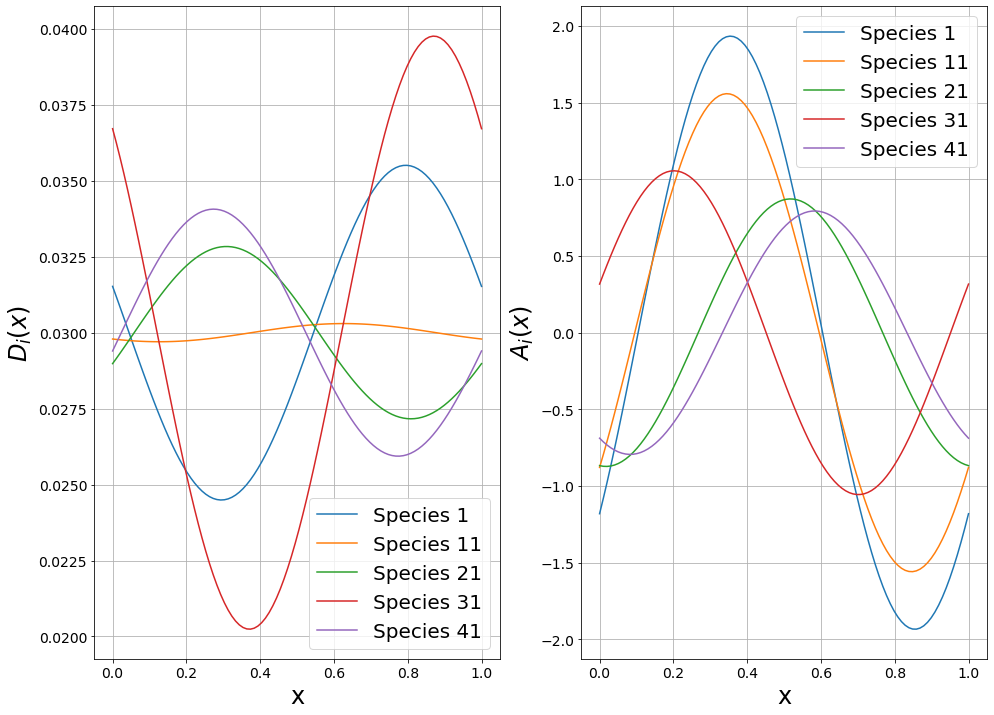

In [4]:
#D     = 0.03*np.ones((ns,1)) 
#Ad    = 1.0*np.ones((ns,1))
#alpha = 3.00*np.ones((ns,1))

# D     = 0.03 + 0.01*np.random.rand(ns)
# Ad    = 1.0*np.random.rand(ns) - 0.5
# alpha = 2.0*np.random.rand(ns) - 1.0

# D     = np.diag(D)
# Ad    = np.diag(Ad)
# alpha = np.diag(alpha)

def DiffFun(x, ns):
    np.random.seed(3)
    DiffC1 = 0.01*np.random.rand(ns) 
    DiffC2 = 2.*np.pi*np.random.rand(ns)
    DiffV  = DiffC1 * np.cos(x*(2.*np.pi)+DiffC2) + 0.03
    #DiffV  = np.zeros(ns)
    DiffM  = np.diag(DiffV)
    return DiffM

def AdvecFun(x, ns):
    np.random.seed(4)
    AdvecC1 = 2.0*np.random.rand(ns)
    AdvecC2 = 2.*np.pi*np.random.rand(ns)
    AdvecV  = AdvecC1 * np.sin(x*(2.*np.pi) + AdvecC2)
    #AdvecV  = np.zeros(ns)
    AdvecM  = np.diag(AdvecV)
    return AdvecM

# def ReacFun(x, ns):
#     np.random.seed(5)
#     ReacM  = np.diag(6.0*np.random.rand(ns) - 3.0)
#     return ReacM
def ReacFun(x, ns):
#     E     = np.linspace(0.0, 4.0, ns-1)
#     T     = 1.0
#     KInel = np.zeros((ns-1,ns-1))
#     for i in range(ns-1):
#         for j in range(i):
#             Deltai     = i-j
#             DeltaE     = E[i]-E[j]
#             KInel[i,j] = 1.e3 * np.exp(-DeltaE/T)
#             KInel[j,i] = KInel[i,j] * np.exp(-DeltaE/T)
#     KInel = KInel - np.diag(np.sum(KInel,axis=1))
#     KDiss = np.exp(E/T)
#     KRec  = KDiss / 100
    E     = np.linspace(0.0, 4.0, ns)
    T     = 1.0
    KInel = np.zeros((ns,ns))
    for i in range(ns):
        for j in range(i):
            Deltai     = i-j
            DeltaE     = E[i]-E[j]
            KInel[i,j] = 1.e0 * np.exp(-DeltaE/T)
            KInel[j,i] = KInel[i,j] * np.exp(-DeltaE/T)
    KInel = KInel - np.diag(np.sum(KInel,axis=1))
    KDiss = 0
    KRec  = 0
    return KInel, KDiss, KRec

KInel, KDiss, KRec = ReacFun(0., ns)
KInelT = KInel.T


NTemp      = 100
DiffMPlot  = np.zeros((ns,NTemp))
AdvecMPlot = np.zeros((ns,NTemp))
ix         = 0
xTemp      = np.linspace(0.,1.,NTemp)
for ix in range(NTemp):
    DiffMPlot[:,ix]  = np.diag(DiffFun(xTemp[ix], ns))
    AdvecMPlot[:,ix] = np.diag(AdvecFun(xTemp[ix], ns))
    ix+=1


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))
Slice = list(range(0,50,10))

ax1.plot(xTemp, DiffMPlot[Slice].T)
ax1.legend(['Species '+str(int(x)+1) for x in Slice], fontsize=20)
ax1.set_xlabel('x', fontsize=24)
ax1.set_ylabel(r'$D_i(x)$', fontsize=24)
#ax1.set_xticks(fontsize=20)
#ax1.set_yticks(fontsize=20)
ax1.grid()

ax2.plot(xTemp, AdvecMPlot[Slice].T)
ax2.legend(['Species '+str(int(x)+1) for x in Slice], fontsize=20)
ax2.set_xlabel('x', fontsize=24)
ax2.set_ylabel(r'$A_i(x)$', fontsize=24)
#ax2.set_xticks(fontsize=20)
#ax2.set_yticks(fontsize=20)
ax2.grid()


plt.show()

In [5]:
#define ode solver
# r = ode(ReacDiffRHS).set_integrator('vode', method='bdf', order=5, atol=1e-10)
# r.set_initial_value(y0, 0.0).set_f_params(dx, D, alpha)

# r = ode(ReacDiffAdvRHS).set_integrator('vode', method='bdf', order=5, atol=1e-10)
# r.set_initial_value(y0, 0.0).set_f_params(dx, DiffM, AdvecM, ReacM)

r = ode(ReacDiffAdvRHS_x).set_integrator('vode', method='bdf', order=5, atol=1e-10)
r.set_initial_value(y0, 0.0).set_f_params(dx, xx, ns, DiffFun, AdvecFun, ReacFun, KInelT, KDiss, KRec)

t1 = 0.1
dt = 0.01

#run integation
xMat  = np.zeros((ns,nx))
yMat  = np.zeros((ns,nx))
yTemp = np.zeros((ns,nx))
for i in range(0,ns):
    xMat[i,:] =  x[0+i*nx:nx+i*nx]
    yMat[i,:] = y0[0+i*nx:nx+i*nx]

tVec = [0.0]  
while r.successful() and r.t < t1:
    print(r.t+dt)
    tVec.append(r.t+dt)
    y_next = r.integrate(r.t+dt)
    for i in range(0,ns):
        yTemp[i,:] = y_next[0+i*nx:nx+i*nx]
    yMat = np.concatenate((yMat,yTemp), axis=1)

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.07
0.08
0.09
0.09999999999999999
0.10999999999999999


In [6]:
fig = plt.figure(figsize=(16, 12))

it = 0
iS = 0
plt.plot(x[0+iS*nx:nx+iS*nx], yMat[iS,0+it*nx:nx+it*nx],  'k-', label='t = '+'{:.2f}'.format(tVec[it])+'s')  
for iS in range(1,ns):
    plt.plot(x[0+iS*nx:nx+iS*nx], yMat[iS,0+it*nx:nx+it*nx],  'k-')  

it = 10
plt.plot(x[0+iS*nx:nx+iS*nx],yMat[iS,0+it*nx:nx+it*nx],  'r-', label='t = '+'{:.2f}'.format(tVec[it])+'s') 
for iS in range(1,ns):
    plt.plot(x[0+iS*nx:nx+iS*nx],yMat[iS,0+it*nx:nx+it*nx],  'r-') 

plt.xlabel('x', fontsize=24)
plt.ylabel(r'$\theta_i$', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.show()

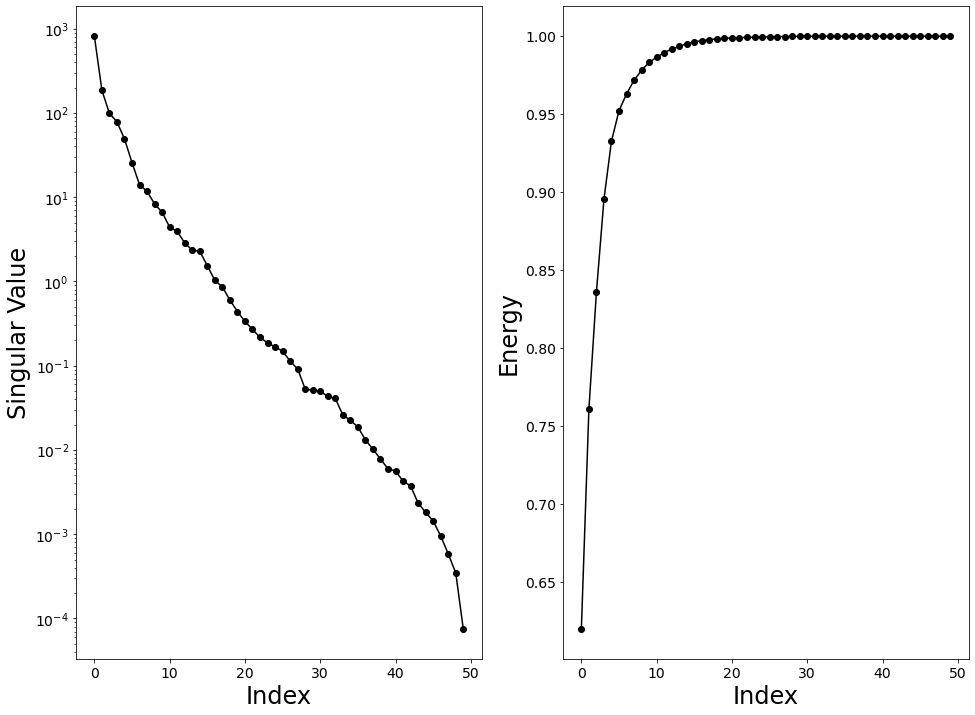

In [7]:
U, S, VT = np.linalg.svd(yMat.T, full_matrices=1)
V        = VT.T

fig1 = plt.figure(figsize=(16, 12))

ax1 = fig1.add_subplot(121)
ax1.semilogy(S,'-o',color='k')
ax1.set_xlabel('Index', fontsize=24)
ax1.set_ylabel('Singular Value', fontsize=24)
#ax1.set_xticks(fontsize=20)
#ax1.set_yticks(fontsize=20)

ax2 = fig1.add_subplot(122)
ax2.plot(np.cumsum(S)/np.sum(S),'-o',color='k')
ax2.set_xlabel('Index', fontsize=24)
ax2.set_ylabel('Energy', fontsize=24)
#ax2.set_xticks(fontsize=20)
#ax2.set_yticks(fontsize=20)

plt.show()

In [8]:
ns_Red          = 10

# from sklearn.decomposition import PCA
# pca             = PCA(n_components=ns_Red, whiten=False)
# yMat_pca        = (np.ascontiguousarray(pca.fit_transform(yMat.T))).T
# yMat_filtered   = pca.inverse_transform(yMat_pca.T)
# singular_values = pca.singular_values_
# AT              = pca.components_.T
yMean           = np.zeros((ns,1))#pca.mean_[...,np.newaxis]
# A               = AT.T
# yMat_ = (np.matmul(yMat_pca.T, A).T) + yMean

from PCAfold import PCA as PCAA
pca        = PCAA(yMat.T, scaling='auto', n_components=ns_Red)
yMat_pca   = pca.transform(yMat.T, nocenter=False)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:ns_Red].T
L          = pca.L
AT         = A.T
# yMat_pca   = ((yMat.T - C)/D).dot(A)
yMat_      = pca.reconstruct(yMat_pca, nocenter=False).T


# A                 = VT
# AT                = V
# yMat_pca          = np.matmul(yMat.T, V).T
# yMean             = np.zeros((ns_Red,1))
# yMat_ = (np.matmul(yMat_pca.T, A).T) + yMean

# ns_Red            = ns
# A                 = np.zeros((ns_Red, ns_Red), int)
# np.fill_diagonal(A, 1)
# AT                = A.T
# yMat_pca          = np.matmul(A, yMat)
# yMean             = np.zeros((ns_Red,1))
# yMat_ = (np.matmul(yMat_pca.T, A).T) + yMean

# from scipy.stats import ortho_group
# A                 = ortho_group.rvs(dim=ns_Red)
# AT                = A.T
# yMat_pca          = np.matmul(A, yMat)
# yMean             = np.zeros((ns_Red,1))
# yMat_ = (np.matmul(yMat_pca.T, A).T) + yMean


## For Verification: 
print('Shape of yMat_pca = ', yMat_pca.shape)
print('Shape of A        = ', A.shape)
print('Error = ', np.max(abs(yMat - yMat_)))

Shape of yMat_pca =  (3600, 10)
Shape of A        =  (10, 50)
Error =  0.2675670807812498


In [9]:
#DIFFUSION-REACTION OF MULTIPLE SCALARS - REDUCED

X_Red  = X
Y0_Red = np.matmul((Y0-yMean).T, AT).T
#Y0_Red = pca.transform(Y0.T, nocenter=False).T
y0_Red = np.zeros((ns_Red*nx))
for i in range(0,ns_Red):
    y0_Red[0+i*nx:nx+i*nx] = Y0_Red[i,:]

    
## For Verification: 
Y0_ = (np.matmul(Y0_Red.T, A) + np.repeat(yMean, Y0_Red.shape[1], axis=1).T).T
#Y0_ = pca.reconstruct(Y0_Red.T, nocenter=False).T
print(np.max(Y0-Y0_))

0.48550427913429406


In [10]:
#RHS function
def ReacDiffAdvRHS_x_Red(x, y, dx, xx, DiffFun, AdvecFun, ReacFun, KInelT, KDiss, KRec, APCA, D):
    ns_Red = APCA.shape[0]
    #print(ns_Red)
    ns     = APCA.shape[1]
    nx     = int(len(y)/ns_Red)
    dydt   = np.zeros(y.shape[0])
    
#     KInelT_Red = np.matmul( APCA, np.matmul(KInelT, APCA.T) )
#     KDiss_Red  = np.matmul( APCA, np.matmul(np.diag(KDiss), APCA.T) )
#     KRec_Red   = np.matmul( APCA, np.matmul(np.diag(KRec), APCA.T) )
    
    Y = np.zeros((ns_Red, nx))
    for iS in range(ns_Red):
        Y[iS,:] = y[0+iS*nx:nx+iS*nx]
        
#     dYdt  = np.zeros((ns,nx))
#     dYdxx = np.zeros((ns,1))
#     for iX in range(-1,nx-1):
#         DiffM      = DiffFun(xx[iX])
#         AdvecM     = AdvecFun(xx[iX])
#         ReacM      = ReacFun(xx[iX])
        
#         Diff       = np.matmul(DiffM, (Y[:,iX+1] - 2.*Y[:,iX] + Y[:,iX-1]) / (dx*dx) )
#         Advec      = np.matmul(AdvecM, (Y[:,iX+1] - Y[:,iX-1]) / (dx) )
#         Reac       = np.matmul(ReacM, Y[:,iX])
#         dYdt[:,iX] = Diff + Advec + Reac

    dYdt_Diff = np.zeros((ns_Red,nx))
    Y_Adv     = np.zeros((ns_Red,nx))
    for iX in range(-1,nx-1):
        DiffM           = DiffFun(xx[iX], ns)
        DiffM_Red       = np.matmul( APCA, np.matmul(DiffM, APCA.T) )
        dYdt_Diff[:,iX] = np.matmul(DiffM_Red, (Y[:,iX+1] - Y[:,iX-1]) / (2.*dx) )
        AdvecM          = AdvecFun(xx[iX], ns)
        AdvecM_Red      = np.matmul( APCA, np.matmul(AdvecM, APCA.T) )
        Y_Adv[:,iX]     = np.matmul(AdvecM_Red, Y[:,iX])
        
    dYdt  = np.zeros((ns_Red,nx))
    for iX in range(-1,nx-1):
        Diff       = (dYdt_Diff[:,iX+1] - dYdt_Diff[:,iX-1]) / (2.*dx)
        Advec      = (    Y_Adv[:,iX+1] -     Y_Adv[:,iX-1]) / (2.*dx)
            
#         #KInel, KDiss, KRec = ReacFun(xx[iX], ns)
#         Reac       = Diff*0.0
#         Reac[0:-1] = (- KDiss*Y[0:-1,iX] + KRec*Y[-1,iX]**2)*Y[-1,iX] #+ (np.matmul(KInelT, Y[0:-1,iX]))*Y[-1,iX]
#         Reac[-1]   = np.sum( (KDiss*Y[0:-1,iX] - KRec*Y[-1,iX]**2)*Y[-1,iX] )
#         Reac       = np.matmul(APCA, Reac)
        
        KInelT_Red = np.matmul( APCA, np.matmul(KInelT, APCA.T) )
        Reac       = np.matmul(KInelT_Red, Y[:,iX])
        
        dYdt[:,iX] = Diff + Advec + Reac
        
    
    dydt = dYdt.flatten()
        
    return dydt

In [11]:
#D_Red      = np.matmul(A, D)
#alpha_Red  = np.matmul(A, alpha)

#D_Red      = np.matmul( A, np.matmul(D, AT) )
#Ad_Red     = np.matmul( A, np.matmul(Ad, AT) )
#alpha_Red  = np.matmul( A, np.matmul(alpha, AT) )


# nx = 300  # number of collocation points
# Lx = 1.0  # domain size 
# dx = Lx/nx           # grid spacing
# x  = np.zeros(nx*ns) 
# for iS in range(0,ns):
#     x[0+iS*nx:nx+iS*nx] = np.linspace(0., Lx-dx, nx)


#define ode solver
r = ode(ReacDiffAdvRHS_x_Red).set_integrator('vode', method='bdf', order=5, atol=1e-15)
r.set_initial_value(y0_Red, 0.0).set_f_params(dx, xx, DiffFun, AdvecFun, ReacFun, KInelT, KDiss, KRec, A, D)


t1 = .1
dt = 0.01

#run integation
xMat_Red  = np.zeros((ns_Red,nx))
yMat_Red  = np.zeros((ns_Red,nx))
yTemp_Red = np.zeros((ns_Red,nx))
for i in range(0,ns_Red):
    xMat_Red[i,:] =  x[0+i*nx:nx+i*nx]
    yMat_Red[i,:] = y0_Red[0+i*nx:nx+i*nx]

tVec = [0.0]  
while r.successful() and r.t < t1:
    print(r.t+dt)
    tVec.append(r.t+dt)
    y_next_Red = r.integrate(r.t+dt)
    for i in range(0,ns_Red):
        yTemp_Red[i,:] = y_next_Red[0+i*nx:nx+i*nx]
    yMat_Red = np.concatenate((yMat_Red,yTemp_Red), axis=1)

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.07
0.08
0.09
0.09999999999999999
0.10999999999999999


In [12]:
yMat_ = (np.matmul(yMat_Red.T, A).T + yMean)
print(np.max(yMat - yMat_))

1.3225218870188478


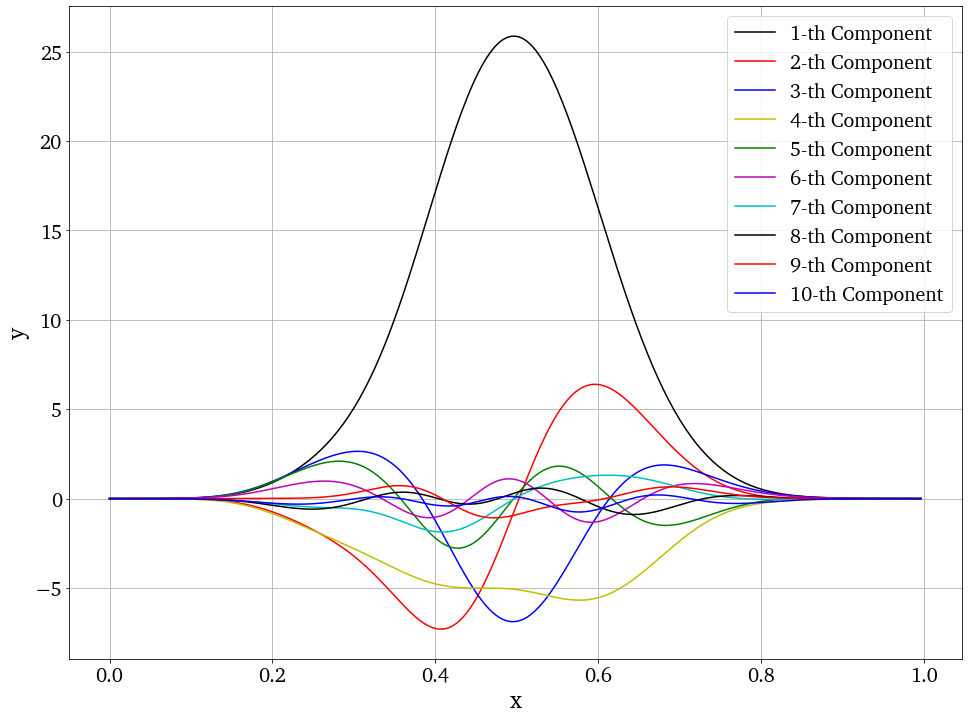

In [13]:
ColorVec = ['k','r','b','y','g','m','c']*10

# for i in range(0,ns):
#     plt.plot(x[0+i*nx:nx+i*nx],y0[0+i*nx:nx+i*nx], 'b-')  #initial condition
fig = plt.figure(figsize=(16, 12))

nt    = int(yMat_Red.shape[1]/nx)
it    = 10
for i in range(0,ns_Red):
    plt.plot(x[0+i*nx:nx+i*nx],yMat_Red[i,0+it*nx:nx+it*nx], ColorVec[i]+'-', label=str(i+1)+'-th Component')  #solutions at time t=t1
    
plt.xlabel('x', fontsize=24)
plt.ylabel('y', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.show()

NYDim  = ns_Red
Header = "# t,x"
for iY in range(NYDim):
    Header = Header + ",y" + str(iY+1)
with open('/Users/sventuri/Desktop/PCA_Data.csv', 'w') as f:
    f.write(Header+'\n')
    iTot=0
    for it in range(nt):
        for ix in range(nx):
            Str = "{:.8e}".format(tVec[it])+','"{:.8e}".format(x[ix])
            for y in yMat_Red[:,iTot]:
                Str = Str + ',' + "{:.8e}".format(y) 
            f.write(Str+'\n')
            iTot+=1

In [14]:
from PCAfold import compute_normalized_variance

depvar_names = ['A'+str(i+1) for i in range(ns)]
# Compute normalized variance quantities:
variance_data = compute_normalized_variance(yMat_pca, yMat.T, depvar_names=depvar_names, bandwidth_values=np.logspace(-3, 1, 20), scale_unit_box=True)

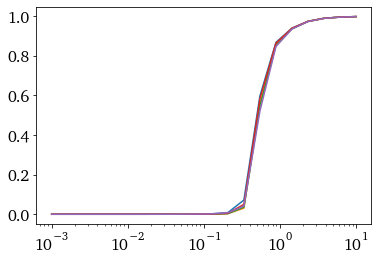

In [15]:
plt.plot(variance_data.bandwidth_values, variance_data.normalized_variance['A1'])
plt.plot(variance_data.bandwidth_values, variance_data.normalized_variance['A2'])
plt.plot(variance_data.bandwidth_values, variance_data.normalized_variance['A3'])
plt.plot(variance_data.bandwidth_values, variance_data.normalized_variance['A4'])
plt.plot(variance_data.bandwidth_values, variance_data.normalized_variance['A50'])
plt.xscale('log')

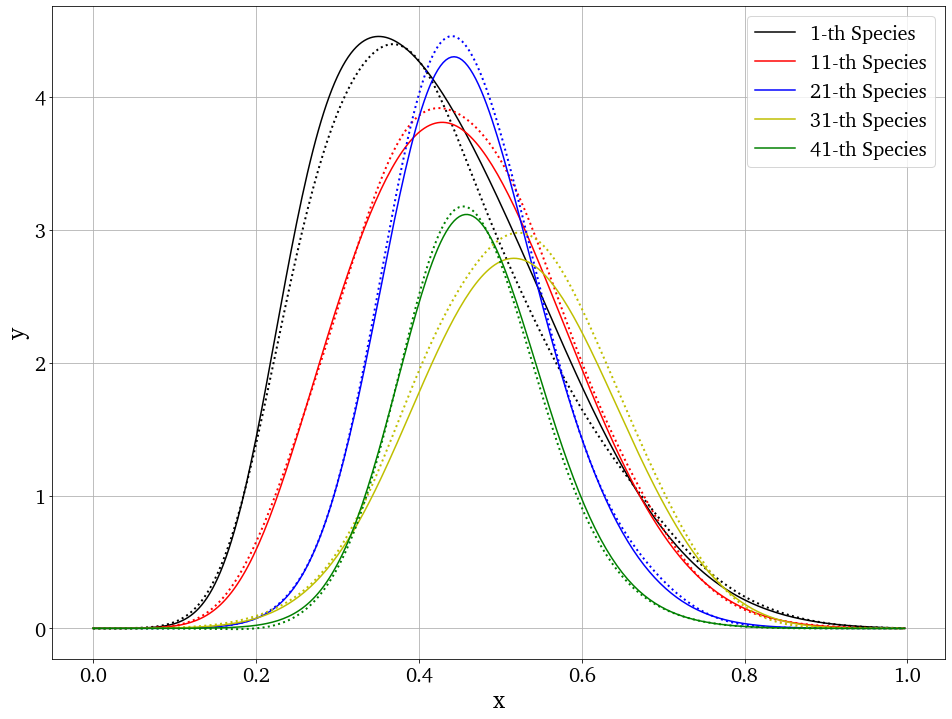

In [16]:
ColorVec = ['k','r','b','y','g','m']

# for i in range(0,ns):
#     plt.plot(x[0+i*nx:nx+i*nx],y0[0+i*nx:nx+i*nx], 'b-')  #initial condition
fig = plt.figure(figsize=(16, 12))

nt    = int(yMat_.shape[1]/nx)
it    = 10
iFig  = 0
for i in range(0,ns,10):
    plt.plot(x[0+i*nx:nx+i*nx],yMat[i,0+it*nx:nx+it*nx],  ColorVec[iFig]+'-', label=str(i+1)+'-th Species')  #solutions at time t=t1
    plt.plot(x[0+i*nx:nx+i*nx],yMat_[i,0+it*nx:nx+it*nx], ColorVec[iFig]+':', linewidth=2)  #solutions at time t=t1
    iFig+=1
    
plt.xlabel('x', fontsize=24)
plt.ylabel('y', fontsize=24)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()

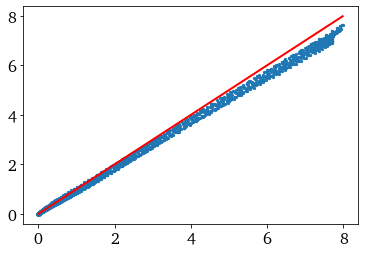

In [17]:
ix  = 1

fig = plt.figure()
plt.scatter(yMat[ix,:], yMat_[ix,:], s=5)
Min = np.amin(yMat[ix,:])
Max = np.amax(yMat[ix,:])
plt.plot([Min,Max], [Min,Max], 'r-', linewidth=2)